# Resnet Tinkering
I am trying to get the following logic to work for a resnet:
- Give a series of input tiles
- Add trainable layers to a pretrained Resnet-50 neural network
- To output a feature vector

This feature vector will be used as an input into a linear regression model.
... this might change given notes in transfer learning walkthrough below.

In [7]:
import numpy as np
import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.utils import img_to_array
from keras.utils.image_dataset import image_dataset_from_directory

# TODO: Figure out which resnet is the best
from keras.applications import ResNet50V2
from keras.applications.resnet import preprocess_input
import random

# First Dummy Example
Using the Keras [transfer learning](https://keras.io/guides/transfer_learning/) walk through, I want to do some transfer learning with a Resnet model trained for image net.

Also making use of [Keras applications](https://keras.io/api/applications/)

In [2]:
import tensorflow_datasets as tfds

# Download [public dataset](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs)
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\emily\tensorflow_datasets\cats_vs_dogs\4.0.0.incompleteYCHPWD\cats_vs_dogs-train.tfrecord*.…

Dataset cats_vs_dogs downloaded and prepared to C:\Users\emily\tensorflow_datasets\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


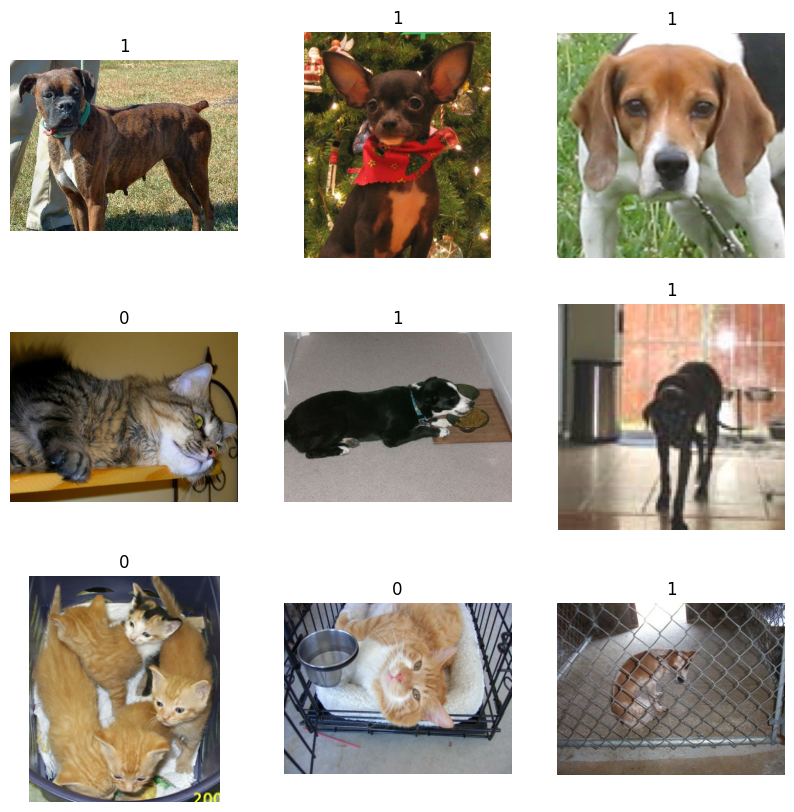

In [3]:
# Plot the first 9 images in training dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

# Standardise data
 - Fixed tile size (this would be handled by my tiling)
 - Normalise pixel values between -1 and 1 ... need to figure this out

**Interesting** - model should handle preprocessing and accept raw data as input (otherwise preprocessing would need to be done outside of model - e.g. on someone's phone). In a real-world application, this could be handled on a server though?


In [4]:
# Resizing
## Handled in data pipeline because "deep neural network can only process contiguous batches of data"
## - contiguous means, together in a sequence
## if we were to resize in neural network, individual tiles would need to be created (whole batch cannot be resized at once)
## This would severely limit ability to pass batches of data through the network I think
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [5]:
# Now batching, caching and prefetching because this apparently optimises loading speeds
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

# Data Augmentation
Introducing new samples by applying realistic transformations to training images (e.g. flipping or rotations)
- "exposes the model to different aspects of the training data while slowing down overfitting"

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


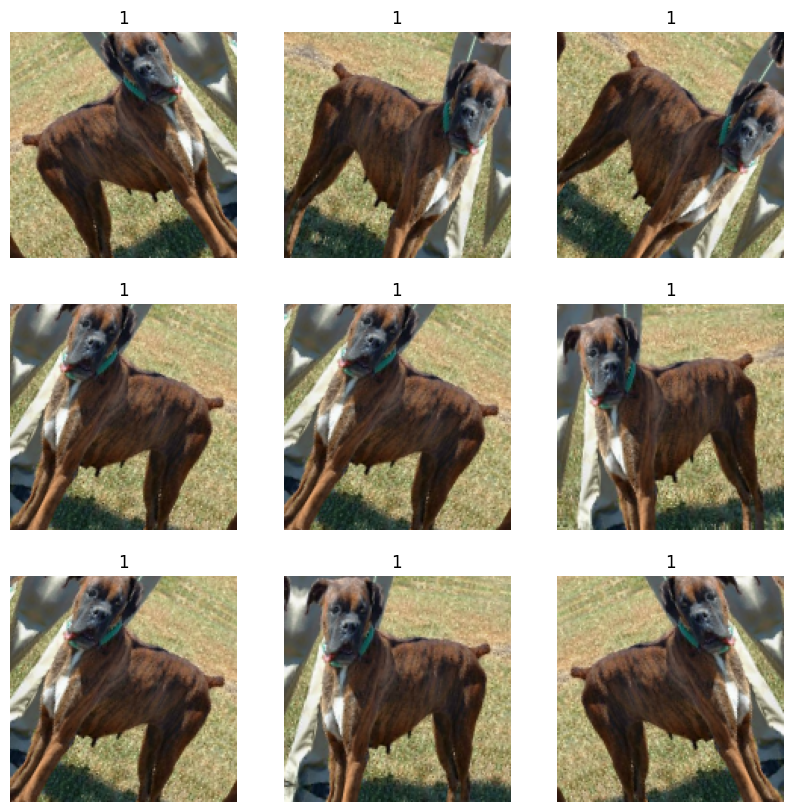

In [9]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

# Building Model
The typical transfer-learning workflow is:
1. Instantiate a base model and load pre-trained weights (e.g. from imagenet)
2. Freeze all layers in base model (i.e. weights won't be changed when training input and output layers)
3. Create a new model on top of output of one or several layers from the base model
4. Train "new" model - ie output model - on new dataset

However!!!
In Yeh et al, they used feature extraction. Which has a slightly more lightweight workflow.
1. Instantiate a base model and load pre-trained weights (e.g. from imagenet)
2. Run the new dataset through pre-trained model and record output of one or more layers from base model.
    - This is called **feature extraction**!
3. Use the output features extracted as input into a new, smaller model

For the latter case, there is a major limitation:
- We cannot dynamically modify input data of new model during training - e.g. with data augmentation
This is a limitation because typiccally with a transfer learning workflow, we are using it because the new dataset (e.g. my satellite tiles) has too little data to train a full model from scratch. Therefore, data augmentation is actually really NB.


In [10]:
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Note for above:
# - input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
# TODO: Look more at input_tensor field

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Resnet weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

94668760/94668760 [==============================] - 29s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

### Definitions
**batchnorm layer**
- network layer that normalises output of one hidden layer before inputting into next hidden layer

**inference**
Evaluating and predicting (instead of training)

**other**
https://keras.io/getting_started/faq/

# Train top layer
Also, remember that "top" means the output layer!

In [ ]:

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 150s 508ms/step - loss: 0.1861 - binary_accuracy: 0.9225 - val_loss: 0.0837 - val_binary_accuracy: 0.9686
Epoch 2/20
291/291 [==============================] - 179s 615ms/step - loss: 0.1367 - binary_accuracy: 0.9469 - val_loss: 0.0790 - val_binary_accuracy: 0.9686
Epoch 3/20
291/291 [==============================] - 192s 660ms/step - loss: 0.1252 - binary_accuracy: 0.9468 - val_loss: 0.0736 - val_binary_accuracy: 0.9690
Epoch 4/20
291/291 [==============================] - 184s 633ms/step - loss: 0.1198 - binary_accuracy: 0.9510 - val_loss: 0.0890 - val_binary_accuracy: 0.9678
Epoch 5/20
291/291 [==============================] - 183s 628ms/step - loss: 0.1162 - binary_accuracy: 0.9519 - val_loss: 0.0734 - val_binary_accuracy: 0.9682
Epoch 6/20
291/291 [==============================] - 191s 657ms/step - loss: 0.1155 - binary_accuracy: 0.9546 - val_loss: 0.0746 - val_binary_accuracy: 0.9716
Epoch 7/20
291/291 [====================

In [ ]:
def decode_image(image):
    image = tf.image.decode(image, channels=8)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [24]:
# Constants
IMAGE_SIZE = (256,256)
IMAGE_CHANNELS=8
SEED= random.randint(0, 10000)

In [25]:
train_path = '../outputs/tiled-satellite-images'

In [26]:
# Generates a `tf.data.Dataset` from image files in a directory
# TODO: Look more at arguments - e.g. defaults for batch size, shuffle; definition of subset
train_dataset = image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    color_mode='rgb')

Found 0 files belonging to 0 classes.
Using 0 files for training.


ValueError: No images found in directory ../outputs/tiled-satellite-images. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

# Issues & Questions Thus Far

### Channels & Resnet input format
Resnet from Keras requires 3 channel images which means that the tiled images don't work (those are 8 channel and also tiffs).

How do I go about still using the 8 channels (as is done in yeh et al)?

As interim, I tried to do just rgb channels and convert to png in [geotiff-to-png](./geotiff-to-png-conversion.ipynb). But I ran into other issues there where the png looks very washed out (see colour scaling below).

Resolution is also still a concern.

### Normalisation
Normalisation is done in the transfer learning step by using a rescaling layer.

This should be easy to incorporate if I get the input format correct.

### Colour Scaling (same as normalisation?)
Colour scaling might be why the images look a bit weird (although I tried to account for this in the conversion in the other notebook).

The Geotiff has a bit-depth of 16 unisgned bits which means that a pixel value can go anywhere from 0 to 2**16-1.

Accounting for this and scaling from 0 to 255 on the RGB channels, created a very washed out image.

### Data augmentation and feature extraction
Yeh et al does feature extraction in there transfer learning approach. At the time, Keras also did not have a resnet model built in so they manually implemented a Resnet 18 architecture.

In my case, I would like to use keras but then I may have the input format issues mentioned above.

Also, the transfer learning tutorial does say it's better to do the typical workflow rather than the "lightweight" workflow but I don't know how that fits in yet to my work.

### Pipeline
https://keras.io/getting_started/intro_to_keras_for_engineers/

### Optimisation
batching, caching and prefetching